In [5]:
# Phase 1 – Data Exploration & Preprocessing
import pandas as pd
import numpy as np
from pathlib import Path

train_path = Path("train_data_ready.csv")
test_path  = Path("test_data_ready.csv")

train_df = pd.read_csv(train_path, low_memory=False)
test_df  = pd.read_csv(test_path,  low_memory=False)

def quick_overview(df, name):
    print(f"=== {name} ===")
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} cols")
    print("Dtypes count:\n", df.dtypes.value_counts())
    print("\nFirst 3 rows:\n", df.head(3))
    print("\nMissing values (top 10):\n", df.isnull().sum().sort_values(ascending=False).head(10))
    print("Duplicate rows:", df.duplicated().sum())

quick_overview(train_df, "TRAIN")
print()
quick_overview(test_df, "TEST")

=== TRAIN ===
Shape: 7352 rows x 563 cols
Dtypes count:
 float64    561
int64        1
object       1
Name: count, dtype: int64

First 3 rows:
    Subject  Activity  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0        1  STANDING           0.288585          -0.020294          -0.132905   
1        1  STANDING           0.278419          -0.016411          -0.123520   
2        1  STANDING           0.279653          -0.019467          -0.113462   

   tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0         -0.995279         -0.983111         -0.913526         -0.995112   
1         -0.998245         -0.975300         -0.960322         -0.998807   
2         -0.995380         -0.967187         -0.978944         -0.996520   

   tBodyAcc-mad()-Y  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.983185  ...                        -0.074323   
1         -0.974914  ...                         0.158075   
2         -0.963668  ...               

Classes (train): ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

Train class distribution:
 Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Test class distribution:
 Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64


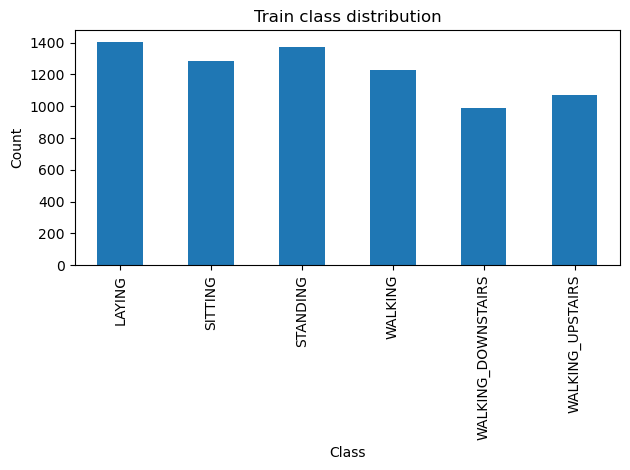

In [6]:
import matplotlib.pyplot as plt

# Find label column
label_col = "Activity"
assert label_col in train_df.columns, "Activity column not found"

print("Classes (train):", sorted(train_df[label_col].unique().tolist()))
print("\nTrain class distribution:\n", train_df[label_col].value_counts())
print("\nTest class distribution:\n", test_df[label_col].value_counts())

# Simple bar chart for train distribution
train_df[label_col].value_counts().sort_index().plot(kind="bar", title="Train class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [7]:
custom_mapping = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

train_df["ActivityId"] = train_df["Activity"].map(custom_mapping)
test_df["ActivityId"]  = test_df["Activity"].map(custom_mapping)

print("Label → ID mapping:")
for cls, idx in custom_mapping.items():
    print(f"{cls} -> {idx}")

print(train_df[["Activity", "ActivityId"]].head())

Label → ID mapping:
WALKING -> 1
WALKING_UPSTAIRS -> 2
WALKING_DOWNSTAIRS -> 3
SITTING -> 4
STANDING -> 5
LAYING -> 6
   Activity  ActivityId
0  STANDING           5
1  STANDING           5
2  STANDING           5
3  STANDING           5
4  STANDING           5


In [8]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# Keep metadata
id_cols = ["Subject"]

# Select feature columns (exclude Activity and ActivityId)
feature_cols = [c for c in train_df.columns if c not in (id_cols + ["Activity", "ActivityId"])]

# Prepare feature and label arrays
X = train_df[feature_cols].values
y = train_df["ActivityId"].values

# Split training set into train and validation (stratified by label)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)

# Quick class distribution check
from collections import Counter

print("Train dist:", Counter(y_train))
print("Val dist:  ", Counter(y_val))

X_train: (5881, 561) y_train: (5881,)
X_val:   (1471, 561) y_val:   (1471,)
Train dist: Counter({6: 1125, 5: 1099, 4: 1029, 1: 981, 2: 858, 3: 789})
Val dist:   Counter({6: 282, 5: 275, 4: 257, 1: 245, 2: 215, 3: 197})


In [9]:
# Scale features using RobustScaler and save artifacts

from sklearn.preprocessing import RobustScaler
import joblib

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(test_df[feature_cols].values)

# Quick check of scaling (first 5 features)
print("Scaled train median (first 5 features):", np.round(np.median(X_train_scaled, axis=0)[:5], 4))
print("Scaled train IQR    (first 5 features):", np.round(np.percentile(X_train_scaled, 75, axis=0)[:5] - 
                                                          np.percentile(X_train_scaled, 25, axis=0)[:5], 4))

# Save artifacts for next phases
np.save("X_train_scaled.npy", X_train_scaled)
np.save("X_val_scaled.npy",   X_val_scaled)
np.save("X_test_scaled.npy",  X_test_scaled)
np.save("y_train.npy",        y_train)
np.save("y_val.npy",          y_val)
np.save("y_test.npy",         test_df["ActivityId"].values)
joblib.dump(scaler, "data/robust_scaler.joblib")

Scaled train median (first 5 features): [0. 0. 0. 0. 0.]
Scaled train IQR    (first 5 features): [1. 1. 1. 1. 1.]


['data/robust_scaler.joblib']

In [10]:
# Phase 2 — Feature Engineering
import numpy as np

X_train = np.load("X_train_scaled.npy")
variances = X_train.var(axis=0)  # column-wise variance

# Quick stats
print("Variance stats:")
print("Min:", variances.min())
print("25th percentile:", np.percentile(variances, 25))
print("Median:", np.median(variances))
print("75th percentile:", np.percentile(variances, 75))
print("Max:", variances.max())

# no need for VarianceThreshold

Variance stats:
Min: 0.2313083862949165
25th percentile: 0.38151635183946464
Median: 0.5549371277270675
75th percentile: 1.1959059655663726
Max: 66.03254186190432


In [11]:
import itertools

# Reload scaled train features
X_train = np.load("X_train_scaled.npy")

# Create DataFrame for correlation analysis (use feature names for clarity)
X_df = pd.DataFrame(X_train, columns=feature_cols)

# Compute absolute correlation matrix
corr_matrix = X_df.corr().abs()

# Set correlation threshold (high because we want only almost-identical features)
threshold = 0.99

# Find all correlated pairs above threshold
corr_pairs = []
for i, j in itertools.combinations(corr_matrix.columns, 2):
    if corr_matrix.loc[i, j] > threshold:
        corr_pairs.append((i, j, corr_matrix.loc[i, j]))

# Info about correlated pairs
print(f"Total correlated pairs above {threshold}: {len(corr_pairs)}")

# Candidate features to drop (we’ll refine later)
to_drop_candidates = list(set([j for i, j, val in corr_pairs]))
print("Candidate features to drop:", len(to_drop_candidates))

Total correlated pairs above 0.99: 205
Candidate features to drop: 121


In [15]:
# Define tolerance for spike difference
# If the max/min differs by more than this, keep both
tolerance = 0.05

# Refined drop list
to_keep_due_spikes = []
to_drop_final = []

for i, j, corr in corr_pairs:
    col_i, col_j = X_df[i], X_df[j]

    # Compare max/min differences
    max_diff = abs(col_i.max() - col_j.max())
    min_diff = abs(col_i.min() - col_j.min())

    if max_diff > tolerance or min_diff > tolerance:
        # Keep both, they capture different extremes
        to_keep_due_spikes.extend([i, j])
    else:
        # Candidate to drop (for now keep only j, as before)
        to_drop_final.append(j)

# Deduplicate
to_keep_due_spikes = list(set(to_keep_due_spikes))
to_drop_final = [f for f in set(to_drop_final) if f not in to_keep_due_spikes]

print("Candidates to drop after spike safeguard:", len(to_drop_final))
print("Kept due to spike differences:", len(to_keep_due_spikes))

Candidates to drop after spike safeguard: 19
Kept due to spike differences: 147


In [17]:
# Train RF on remaining features (X_train_scaled)

# Mask of features kept
mask_keep = [f not in to_drop_final for f in feature_cols]

# Apply mask
X_train_temp = X_train_scaled[:, mask_keep]

# Update feature names to match kept columns
feature_names_temp = [f for f, keep in zip(feature_cols, mask_keep) if keep]

# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_temp, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names_temp,   # ✅ use updated list
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Decide importance threshold (e.g., keep top 95% cumulative importance)
cumulative_importance = feature_importance_df['importance'].cumsum()
threshold_idx = np.where(cumulative_importance >= 0.95)[0][0]
important_features = feature_importance_df['feature'].iloc[:threshold_idx+1].tolist()

print("Number of important features:", len(important_features))

# Refine final drop list 
to_drop_final_refined = [f for f in to_drop_final if f not in important_features]

print("Number of features to drop after importance safeguard:", len(to_drop_final_refined))

NameError: name 'RandomForestClassifier' is not defined

In [14]:
# Apply Final Drop List & Save Reduced Data

# Convert final drop list into mask
drop_set = set(to_drop_final_refined)
keep_features = [f for f in feature_cols if f not in drop_set]

# Create a boolean mask for kept features
mask = np.array([f in keep_features for f in feature_cols])

# Apply mask to scaled arrays
X_train_final = X_train_scaled[:, mask]
X_val_final   = X_val_scaled[:, mask]
X_test_final  = X_test_scaled[:, mask]

print("Final feature count:", len(keep_features))
print("Final shapes:")
print("X_train_final:", X_train_final.shape)
print("X_val_final:  ", X_val_final.shape)
print("X_test_final: ", X_test_final.shape)

# Save reduced datasets
np.save("X_train_final.npy", X_train_final)
np.save("X_val_final.npy",   X_val_final)
np.save("X_test_final.npy",  X_test_final)

# Save final kept feature names
pd.Series(keep_features).to_csv("final_features.csv", index=False, header=False)

NameError: name 'to_drop_final_refined' is not defined

In [ ]:
# Class Remapping

# If running in Jupyter, enable inline plots
%matplotlib inline

# Files we expect (created earlier)
# - X_train_final.npy, X_val_final.npy, X_test_final.npy 
# - y_train.npy, y_val.npy, y_test.npy
# - final_features.csv (list of kept features)

# Load existing label arrays and inspect
y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")
y_test  = np.load("y_test.npy")

print("Unique ActivityId values (train):", np.unique(y_train))
print("Train counts (ActivityId):", Counter(y_train))
print("Val counts (ActivityId):", Counter(y_val))
print("Test counts (ActivityId):", Counter(y_test))

In [ ]:
# Define mapping (ActivityId -> AppClass)
# Earlier custom mapping was:
# 1 WALKING, 2 WALKING_UPSTAIRS, 3 WALKING_DOWNSTAIRS, 4 SITTING, 5 STANDING, 6 LAYING

# App classes integers chosen:
# 0 = SEDENTARY (SITTING + LAYING)
# 1 = STANDING
# 2 = ACTIVE (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS)

activityid_to_app = {1: 2, 2: 2, 3: 2, 4: 0, 5: 1, 6: 0}

# human readable mapping
app_to_name = {0: "SEDENTARY", 1: "STANDING", 2: "ACTIVE"}

# Map labels, with safety checks
def map_activityid_array(arr, mapping):
    # Check all values exist in mapping
    vals = np.unique(arr)
    missing = [v for v in vals if v not in mapping]
    if missing:
        raise ValueError(f"Found ActivityId values not in mapping: {missing}")
    return np.array([mapping[x] for x in arr])

y_train_app = map_activityid_array(y_train, activityid_to_app)
y_val_app   = map_activityid_array(y_val,   activityid_to_app)
y_test_app  = map_activityid_array(y_test,  activityid_to_app)

# Quick stats
print("Mapped train app class counts:", Counter(y_train_app))
print("Mapped val app class counts:  ", Counter(y_val_app))
print("Mapped test app class counts: ", Counter(y_test_app))

In [ ]:
# Plot distributions for train/val/test
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, (arr, title) in zip(axes, [(y_train_app,'Train'),(y_val_app,'Validation'),(y_test_app,'Test')]):
    counts = pd.Series(arr).value_counts().sort_index()
    counts.index = counts.index.map(lambda x: app_to_name[x])
    counts.plot(kind='bar', ax=ax, title=f"{title} class distribution")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Save arrays and small mapping CSV for reproducibility
np.save("y_train_app.npy", y_train_app)
np.save("y_val_app.npy",   y_val_app)
np.save("y_test_app.npy",  y_test_app)

# Save mapping as human-readable CSV
mapping_rows = []
for aid, app in activityid_to_app.items():
    mapping_rows.append({
        "ActivityId": int(aid),
        "ActivityName": activityid_to_name[aid],
        "AppClassId": int(app),
        "AppClassName": app_to_name[app]
    })
pd.DataFrame(mapping_rows).to_csv("label_mapping_app.csv", index=False)

# Save app class names
pd.Series(app_to_name).to_csv("app_class_names.csv", header=["class_name"])
print("Saved y_train_app.npy, y_val_app.npy, y_test_app.npy, and label_mapping_app.csv")

In [ ]:
# Final sanity checks before moving to feature engineering
# Ensure no NaNs
for arr, name in [(y_train_app,"y_train_app"), (y_val_app,"y_val_app"), (y_test_app,"y_test_app")]:
    if np.isnan(arr).any():
        raise ValueError(f"{name} contains NaN values")
print("No NaNs in mapped label arrays.")

# Ensure shapes consistent with feature arrays
# Load feature arrays
X_train_final, X_val_final, X_test_final = [np.load(f) for f in ("X_train_final.npy", "X_val_final.npy", "X_test_final.npy")]

print("Shapes check:")
print("X_train_final:", X_train_final.shape, "y_train_app:", y_train_app.shape)
print("X_val_final:  ", X_val_final.shape,   "y_val_app:  ", y_val_app.shape)
print("X_test_final: ", X_test_final.shape,  "y_test_app: ", y_test_app.shape)

# If shapes mismatch (rows), stop here and we need to align splits.
if X_train_final.shape[0] != y_train_app.shape[0] or X_val_final.shape[0] != y_val_app.shape[0] or X_test_final.shape[0] != y_test_app.shape[0]:
    raise ValueError("Row count mismatch between X and y arrays. Double-check the train/val/test splits.")
print("Shapes align. Ready to proceed to feature selection & windowing.")

In [ ]:
# Load reduced features and new labels
from sklearn.ensemble import RandomForestClassifier

# Load features (already reduced by correlation pruning)
X_train, X_val, X_test = [np.load(f) for f in ("X_train_final.npy","X_val_final.npy","X_test_final.npy")]

# Load new 3-class labels
y_train_app, y_val_app, y_test_app = [np.load(f) for f in ("data/y_train_app.npy","data/y_val_app.npy","data/y_test_app.npy")]

# Load feature names for tracking
feature_names = pd.read_csv("final_features.csv", header=None).squeeze("columns").tolist()

# Quick sanity check
print("Shapes:")
print("X_train:", X_train.shape, "y_train_app:", y_train_app.shape)
print("X_val:  ", X_val.shape,   "y_val_app:", y_val_app.shape)
print("X_test: ", X_test.shape,  "y_test_app:", y_test_app.shape)
print("Number of features:", len(feature_names))

In [ ]:
# Train Random Forest for feature importance
rf = RandomForestClassifier(
    n_estimators=300, 
    random_state=42, 
    n_jobs=-1,
    class_weight="balanced"  # handle class imbalance safely
)

rf.fit(X_train, y_train_app)

importances = rf.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Save importance ranking
importance_df.to_csv("feature_importances_rf.csv", index=False)

print("Top 10 most important features:")
print(importance_df.head(10))

In [ ]:
# Plot cumulative importance curve
cumulative = importance_df["importance"].cumsum()

plt.figure(figsize=(8,5))
plt.plot(cumulative.index, cumulative, marker=".")
plt.axhline(y=0.95, color="red", linestyle="--", label="95% cutoff")
plt.xlabel("Number of features")
plt.ylabel("Cumulative importance")
plt.title("Feature importance cumulative curve")
plt.legend()
plt.grid(True)
plt.show()

# Find number of features needed for 95% importance
n_keep = np.where(cumulative >= 0.95)[0][0] + 1
print(f"Number of features needed for 95% importance: {n_keep}")

In [4]:
# Select and save reduced feature set
# Keep top features covering 95% of importance
top_features = importance_df["feature"].iloc[:n_keep].tolist()

# Create boolean mask for these features
mask = [f in top_features for f in feature_names]

X_train_sel = X_train[:, mask]
X_val_sel   = X_val[:, mask]
X_test_sel  = X_test[:, mask]

print("Original features:", X_train.shape[1])
print("Kept features:", X_train_sel.shape[1])

# Save reduced arrays
np.save("X_train_sel.npy", X_train_sel)
np.save("X_val_sel.npy",   X_val_sel)
np.save("X_test_sel.npy",  X_test_sel)
pd.Series(top_features).to_csv("selected_features.csv", index=False, header=False)
print("Saved reduced feature arrays and feature list.")

NameError: name 'importance_df' is not defined

In [ ]:
# Modeling
# 1 – Load Data for Modeling
import numpy as np
import pandas as pd
from collections import Counter

# Load feature arrays
X_train = np.load("data/X_train_sel.npy")
X_val   = np.load("data/X_val_sel.npy")
X_test  = np.load("data/X_test_sel.npy")

# Load app class labels
y_train = np.load("data/y_train_app.npy")
y_val   = np.load("data/y_val_app.npy")
y_test  = np.load("data/y_test_app.npy")

# Load feature names
feature_names = pd.read_csv("data/selected_features.csv", header=None).squeeze("columns").tolist()

# Quick sanity check
print("Feature shapes:")
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)
print("\nLabel shapes:")
print("y_train:", y_train.shape)
print("y_val:  ", y_val.shape)
print("y_test: ", y_test.shape)

# Check class distribution
print("\nClass distribution (train):", Counter(y_train))
print("Class distribution (val):  ", Counter(y_val))
print("Class distribution (test): ", Counter(y_test))

Feature shapes:
X_train: (5881, 245)
X_val:   (1471, 245)
X_test:  (2947, 245)

Label shapes:
y_train: (5881,)
y_val:   (1471,)
y_test:  (2947,)

Class distribution (train): Counter({2: 2628, 0: 2154, 1: 1099})
Class distribution (val):   Counter({2: 657, 0: 539, 1: 275})
Class distribution (test):  Counter({2: 1387, 0: 1028, 1: 532})


Validation Accuracy: 0.9878

Classification Report:

              precision    recall  f1-score   support

   SEDENTARY       0.99      0.98      0.98       539
    STANDING       0.96      0.98      0.97       275
      ACTIVE       1.00      1.00      1.00       657

    accuracy                           0.99      1471
   macro avg       0.98      0.99      0.98      1471
weighted avg       0.99      0.99      0.99      1471



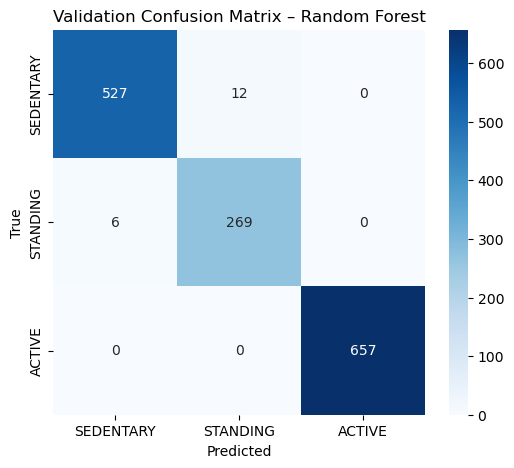

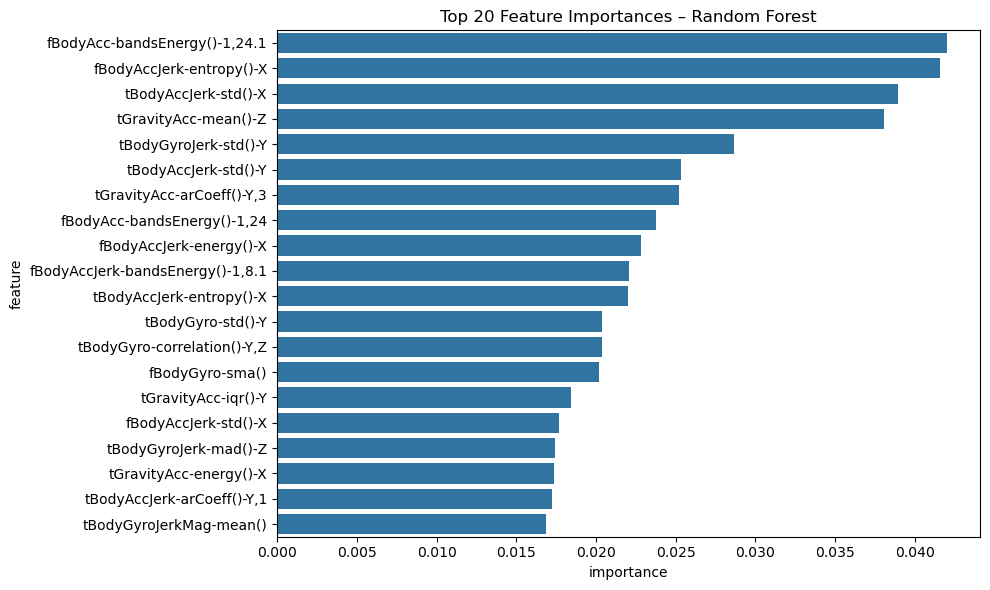

In [471]:
# 2 – Baseline Random Forest Training
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=300,        # number of trees
    random_state=42,
    n_jobs=-1,               # parallelize
    class_weight="balanced"  # handle class imbalance
)

# Train on training data
rf.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf.predict(X_val)

# Evaluate
acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {acc:.4f}\n")

print("Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=["SEDENTARY","STANDING","ACTIVE"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["SEDENTARY","STANDING","ACTIVE"],
            yticklabels=["SEDENTARY","STANDING","ACTIVE"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix – Random Forest")
plt.show()

# Feature importance plot
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=importance_df.head(20))
plt.title("Top 20 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

In [ ]:
# 3 – Advanced Modeling & Optimization
# 3.1 — Load Data for Advanced Modeling
# Imports
import numpy as np
import pandas as pd
from collections import Counter

# Load reduced feature arrays
X_train = np.load("data/X_train_sel.npy")
X_val   = np.load("data/X_val_sel.npy")
X_test  = np.load("data/X_test_sel.npy")

# Load 3-class labels
y_train = np.load("data/y_train_app.npy")
y_val   = np.load("data/y_val_app.npy")
y_test  = np.load("data/y_test_app.npy")

# Load feature names for tracking and future reference
feature_names = pd.read_csv("data/selected_features.csv", header=None).squeeze("columns").tolist()

# Quick sanity check
print("Feature shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:", y_val.shape)
print("X_test: ", X_test.shape,  "y_test:", y_test.shape)

# Check class distribution
print("\nClass distribution (train):", Counter(y_train))
print("Class distribution (val):  ", Counter(y_val))
print("Class distribution (test): ", Counter(y_test))

Feature shapes:
X_train: (5881, 245) y_train: (5881,)
X_val:   (1471, 245) y_val: (1471,)
X_test:  (2947, 245) y_test: (2947,)

Class distribution (train): Counter({2: 2628, 0: 2154, 1: 1099})
Class distribution (val):   Counter({2: 657, 0: 539, 1: 275})
Class distribution (test):  Counter({2: 1387, 0: 1028, 1: 532})


In [473]:
# 3.2 — Train Baseline Classifiers
# Imports for models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Create dictionary to store models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42)
}

# Train each model and evaluate on validation set
baseline_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_val_pred, target_names=["SEDENTARY","STANDING","ACTIVE"]))

    baseline_results[name] = acc


Training RandomForest...
RandomForest Validation Accuracy: 0.9878
              precision    recall  f1-score   support

   SEDENTARY       0.99      0.98      0.98       539
    STANDING       0.96      0.98      0.97       275
      ACTIVE       1.00      1.00      1.00       657

    accuracy                           0.99      1471
   macro avg       0.98      0.99      0.98      1471
weighted avg       0.99      0.99      0.99      1471


Training GradientBoosting...
GradientBoosting Validation Accuracy: 0.9905
              precision    recall  f1-score   support

   SEDENTARY       0.99      0.98      0.99       539
    STANDING       0.97      0.98      0.97       275
      ACTIVE       1.00      1.00      1.00       657

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471


Training KNN...
KNN Validation Accuracy: 0.9776
              precision    recall  f1-score   s

In [ ]:
# 3.3 – Hyperparameter Tuning for Gradient Boosting
# Load the Data
import numpy as np
from collections import Counter

# Load reduced feature arrays
X_train = np.load("data/X_train_sel.npy")
X_val   = np.load("data/X_val_sel.npy")
X_test  = np.load("data/X_test_sel.npy")

# Load Labels
y_train = np.load("data/y_train_app.npy")
y_val   = np.load("data/y_val_app.npy")
y_test  = np.load("data/y_test_app.npy")

# Quick check
print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:", y_val.shape)
print("X_test: ", X_test.shape,  "y_test:", y_test.shape)

# Class distributions
print("Train distribution:", Counter(y_train))
print("Validation distribution:", Counter(y_val))
print("Test distribution:", Counter(y_test))

Shapes:
X_train: (5881, 245) y_train: (5881,)
X_val:   (1471, 245) y_val: (1471,)
X_test:  (2947, 245) y_test: (2947,)
Train distribution: Counter({2: 2628, 0: 2154, 1: 1099})
Validation distribution: Counter({2: 657, 0: 539, 1: 275})
Test distribution: Counter({2: 1387, 0: 1028, 1: 532})


In [476]:
# Define the Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier

# Baseline GB model
gb = GradientBoostingClassifier(
    n_estimators=300,   # number of boosting rounds
    learning_rate=0.1,  # step size shrinkage
    max_depth=3,        # depth of each tree
    random_state=42
)

# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0],           # fraction of samples per tree
    'min_samples_split': [2, 5, 10]    # min samples to split internal node
}

# Perform Grid Search
from sklearn.model_selection import GridSearchCV

# Grid search with 3-fold CV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,            # 3-fold cross-validation
    n_jobs=-1,       # parallelize
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END learning_rate=0.05, max_depth=2, min_samples_split=2, n_estimators=300, subsample=0.8; total time= 2.2min
[CV] END learning_rate=0.05, max_depth=2, min_samples_split=2, n_estimators=500, subsample=1.0; total time= 4.4min
[CV] END learning_rate=0.05, max_depth=2, min_samples_split=5, n_estimators=500, subsample=1.0; total time= 4.6min
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time= 1.4min
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=300, subsample=1.0; total time= 4.6min
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=100, subsample=1.0; total time= 1.7min
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=300, subsample=0.8; total time= 4.1min
[CV] END learning

Gradient Boosting Validation Accuracy: 0.9946

Classification Report:

              precision    recall  f1-score   support

   SEDENTARY       1.00      0.99      0.99       539
    STANDING       0.98      0.99      0.99       275
      ACTIVE       1.00      1.00      1.00       657

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



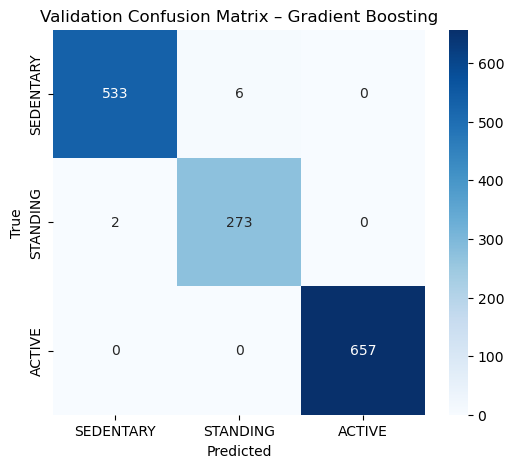

In [477]:
best_gb = grid_search.best_estimator_

# Predict on validation set
y_val_pred = best_gb.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

acc = accuracy_score(y_val, y_val_pred)
print(f"Gradient Boosting Validation Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=["SEDENTARY","STANDING","ACTIVE"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["SEDENTARY","STANDING","ACTIVE"],
            yticklabels=["SEDENTARY","STANDING","ACTIVE"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix – Gradient Boosting")
plt.show()

Gradient Boosting Test Accuracy: 0.9647

Classification Report (Test Set):

              precision    recall  f1-score   support

   SEDENTARY       0.96      0.93      0.95      1028
    STANDING       0.88      0.93      0.91       532
      ACTIVE       1.00      1.00      1.00      1387

    accuracy                           0.96      2947
   macro avg       0.95      0.96      0.95      2947
weighted avg       0.97      0.96      0.96      2947



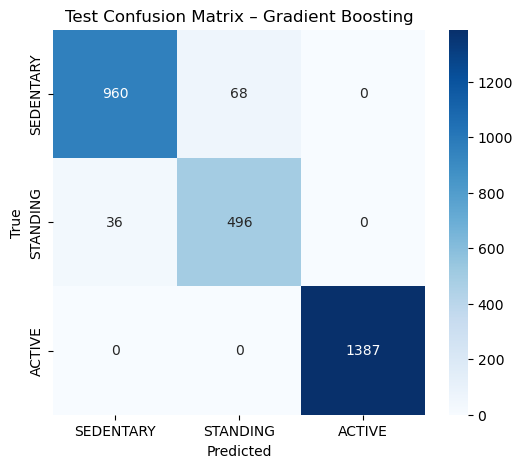

In [478]:
# Predict on test set
y_test_pred = best_gb.predict(X_test)

# Accuracy and classification report
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Gradient Boosting Test Accuracy: {test_acc:.4f}")
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_test_pred, target_names=["SEDENTARY","STANDING","ACTIVE"]))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d",
            xticklabels=["SEDENTARY","STANDING","ACTIVE"],
            yticklabels=["SEDENTARY","STANDING","ACTIVE"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix – Gradient Boosting")
plt.show()

In [ ]:
import joblib

joblib.dump(best_gb, "data/best_gradient_boosting_model.joblib")

['best_gradient_boosting_model.joblib']

In [480]:
importances = best_gb.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Top 20 features
print(importance_df.head(20))

                             feature  importance
170            tBodyGyroJerk-std()-Y    0.213410
176        tGravityAcc-arCoeff()-Y,3    0.154049
13          fBodyAccJerk-entropy()-X    0.140873
243    fBodyAcc-bandsEnergy()-1,24.1    0.138932
22              tGravityAcc-mean()-Z    0.050870
141            tBodyGyroJerk-min()-X    0.049459
173      fBodyAcc-bandsEnergy()-1,24    0.031175
19              tBodyAccJerk-std()-X    0.022655
21             tBodyGyroJerk-mad()-Z    0.018039
26              angle(X,gravityMean)    0.015811
209        tGravityAcc-arCoeff()-Y,4    0.013249
182  fBodyGyro-bandsEnergy()-57,64.2    0.010140
101           tBodyGyroJerkMag-iqr()    0.009264
158        tGravityAcc-arCoeff()-X,4    0.008678
73                 fBodyGyro-std()-X    0.006416
7    fBodyAccJerk-bandsEnergy()-1,16    0.005840
104          tBodyGyroJerkMag-mean()    0.005741
71                  fBodyAcc-iqr()-Y    0.005712
203            tBodyGyro-entropy()-Y    0.005611
27             tBody

In [2]:
from sklearn.preprocessing import RobustScaler
import joblib

# Fit scaler on the 245-feature training set
scaler_final = RobustScaler()
scaler_final.fit(X_train_final)

# Save it
joblib.dump(scaler_final, "robust_scaler_final.joblib")
from sklearn.preprocessing import RobustScaler
import joblib

# Assume X_train_final is your 245-feature training data
print("Shape of training data:", X_train_final.shape)  # Should be (num_samples, 245)

# Fit scaler on this data
scaler_final = RobustScaler()
scaler_final.fit(X_train_final)

# Confirm the number of features in the scaler matches your training data
print("Number of features in scaler:", scaler_final.scale_.shape[0])  # Should be 245

# Save the new scaler
joblib.dump(scaler_final, "robust_scaler_final.joblib")
print("Scaler saved successfully as 'robust_scaler_final.joblib'")

NameError: name 'X_train_final' is not defined

In [ ]:
import numpy as np
import joblib

# Load X_train_sel
X_train_sel = np.load("data/X_train_sel.npy")  # adjust path if needed
print("Shape of X_train_sel:", X_train_sel.shape)  # should be (n_samples, 245)

scaler = RobustScaler()
scaler.fit(X_train_sel)

print("Scaler fitted with", scaler.scale_.shape[0], "features")  # should print 245

joblib.dump(scaler, "model/robust_scaler_final.joblib")
print("Scaler saved successfully!")